In [81]:
# Import Libraries

import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
import os
import json
import twitter
import tweepy
from pandas.io.json import json_normalize
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from itertools import islice
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
# Import Dataset
df = pd.read_csv('Tweets.csv')
df.head()

,created_at,full_text,source,geo,lang,entities.hashtags
0,Sun Oct 10 23:38:18 +0000 2021,@lysisbunny @wheeingloss Dm me if you need hel...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[]
1,Sun Oct 10 23:38:15 +0000 2021,RT @nope_thank_u: OR countless other Māori org...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[]
2,Sun Oct 10 23:37:50 +0000 2021,RT @voicesofvv: Driving around to our usual sp...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,en,[]
3,Sun Oct 10 23:37:41 +0000 2021,RT @roshan_pie: I'm struggling financially rig...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[]
4,Sun Oct 10 23:37:15 +0000 2021,@babyygirlvenus Dm me if you need help with bi...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[]


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2523 entries, 0 to 2522
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   created_at         2523 non-null   object 
 1   full_text          2523 non-null   object 
 2   source             2523 non-null   object 
 3   geo                0 non-null      float64
 4   lang               2523 non-null   object 
 5   entities.hashtags  2523 non-null   object 
dtypes: float64(1), object(5)
memory usage: 69.1+ KB


In [23]:
# function to help cleanup text

def clean_text(text):
    text=text.lower()
    text=re.sub('\\d|\\W+|_',' ',text)
    text=re.sub('[^a-zA-Z]'," ", text)
    
    return text

In [24]:
# Take the variable "source" and create a new column finding where the greater-than symbol is
# then take that and use it to slice out the last bit of the phrase (we only want the part that says "twitter for iphone", etc)

df['pos'] = df['source'].str.find('">')
df['new_var'] = df.apply(lambda x: x['source'][x['pos']:],axis=1)

In [25]:
# clean dat text

df['almost_sources'] = df['new_var'].apply(clean_text)

In [26]:
# slice off the last 3 characters because they are all "_a"

df['final_sources'] = df.almost_sources.str[:-3]

In [27]:
# take a quick peek

df.head()

,created_at,full_text,source,geo,lang,entities.hashtags,pos,new_var,almost_sources,final_sources
0,Sun Oct 10 23:38:18 +0000 2021,@lysisbunny @wheeingloss Dm me if you need hel...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[],58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone
1,Sun Oct 10 23:38:15 +0000 2021,RT @nope_thank_u: OR countless other Māori org...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[],58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone
2,Sun Oct 10 23:37:50 +0000 2021,RT @voicesofvv: Driving around to our usual sp...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,en,[],50,""">Twitter Web App</a>",twitter web app a,twitter web app
3,Sun Oct 10 23:37:41 +0000 2021,RT @roshan_pie: I'm struggling financially rig...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[],58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone
4,Sun Oct 10 23:37:15 +0000 2021,@babyygirlvenus Dm me if you need help with bi...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[],58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone


In [28]:
# in addition to the 4 graphs created for milestone 1, I wanted to see if there is anything interesting with the tweet sources
# I am grouping them by their source, sorting the values, only keeping the top 5 most frequent, and resetting the index.

source_df = df.groupby(['final_sources']).size().to_frame().sort_values([0], ascending=False).head(5).reset_index()
source_df.columns = ['sources','count']

In [29]:
source_df

,sources,count
0,twitter for iphone,1550
1,twitter for android,547
2,twitter web app,344
3,twitter for ipad,38
4,tweetdeck,7


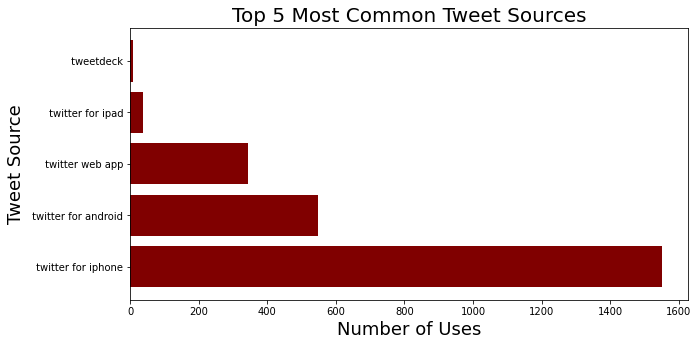

In [30]:
# This bar chart shows that by far & away, most of the tweets were generated on the twitter iphone app.

fig = plt.figure(figsize=(10,5))
plt.barh(source_df['sources'], source_df['count'], color='maroon')
plt.xlabel('Number of Uses', fontsize=18)
plt.ylabel('Tweet Source', fontsize=18)
plt.title('Top 5 Most Common Tweet Sources', fontsize=20)
plt.show()

In [59]:
# functions to clean & preprocess the text

def clean_text(text):
    text=text.lower()
    text=re.sub('\\d|\\W+|_',' ',text)
    text=re.sub('[^a-zA-Z]'," ", text)
    
    return text
    
def tokenize(text):
    stop_words = stopwords.words('english') + ADDITIONAL_STOPWORDS
    txt_token= word_tokenize(text)
    txt_no_stopwords = [word for word in txt_token if word not in stop_words]
    
    return txt_no_stopwords

ADDITIONAL_STOPWORDS = ['paypal','venmo','zelle','cashapp']


def stem_text(word_list):
    porter = PorterStemmer()
    
    return [porter.stem(word) for word in word_list]

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review) # calculating the polarity scores for each doc in the corpus
    return vs['compound'] # returning the compound score
    
    
def vader_analysis(compound): # setting thresholds for what compound scores are considered positive, negative, or neutral
    if compound >=0.5:
        return 'Positive'
    elif compound <0:
        return 'Negative'
    else:
        return 'Neutral'

In [37]:
# apply the cleaning, tokenizing, & stemming

df['txt_clean'] = df['full_text'].apply(clean_text)
df['txt_tokenized'] = df['txt_clean'].apply(tokenize)
df['txt_stemmed'] = df['txt_tokenized'].apply(stem_text)
df['text_final'] = df['txt_stemmed'].apply(lambda text: ' '.join(text))

,created_at,full_text,source,geo,lang,entities.hashtags,pos,new_var,almost_sources,final_sources,txt_clean,txt_tokenized,txt_stemmed,text_final
0,Sun Oct 10 23:38:18 +0000 2021,@lysisbunny @wheeingloss Dm me if you need hel...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[],58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone,lysisbunny wheeingloss dm me if you need help...,"[lysisbunny, wheeingloss, dm, need, help, bill...","[lysisbunni, wheeingloss, dm, need, help, bill...",lysisbunni wheeingloss dm need help bill cash app
1,Sun Oct 10 23:38:15 +0000 2021,RT @nope_thank_u: OR countless other Māori org...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[],58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone,rt nope thank u or countless other m ori organ...,"[rt, nope, thank, u, countless, ori, organisat...","[rt, nope, thank, u, countless, ori, organis, ...",rt nope thank u countless ori organis fight or...
2,Sun Oct 10 23:37:50 +0000 2021,RT @voicesofvv: Driving around to our usual sp...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,en,[],50,""">Twitter Web App</a>",twitter web app a,twitter web app,rt voicesofvv driving around to our usual spot...,"[rt, voicesofvv, driving, around, usual, spots...","[rt, voicesofvv, drive, around, usual, spot, w...",rt voicesofvv drive around usual spot weekli d...
3,Sun Oct 10 23:37:41 +0000 2021,RT @roshan_pie: I'm struggling financially rig...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[],58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone,rt roshan pie i m struggling financially right...,"[rt, roshan, pie, struggling, financially, rig...","[rt, roshan, pie, struggl, financi, right, emp...",rt roshan pie struggl financi right employ end...
4,Sun Oct 10 23:37:15 +0000 2021,@babyygirlvenus Dm me if you need help with bi...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[],58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone,babyygirlvenus dm me if you need help with bi...,"[babyygirlvenus, dm, need, help, bills, cash, ...","[babyygirlvenu, dm, need, help, bill, cash, app]",babyygirlvenu dm need help bill cash app


In [62]:
# initializing the analyzer from Vader

analyzer = SentimentIntensityAnalyzer()

# creating 2 new columns in the dataframe applying the two functions defined above

df['Vader Sentiment'] = df['text_final'].apply(vadersentimentanalysis)
df['Vader Analysis'] = df['Vader Sentiment'].apply(vader_analysis)
df.head()

,created_at,full_text,source,geo,lang,entities.hashtags,pos,new_var,almost_sources,final_sources,txt_clean,txt_tokenized,txt_stemmed,text_final,Vader Sentiment,Vader Analysis
0,Sun Oct 10 23:38:18 +0000 2021,@lysisbunny @wheeingloss Dm me if you need hel...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[],58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone,lysisbunny wheeingloss dm me if you need help...,"[lysisbunny, wheeingloss, dm, need, help, bill...","[lysisbunni, wheeingloss, dm, need, help, bill...",lysisbunni wheeingloss dm need help bill cash app,0.4019,Neutral
1,Sun Oct 10 23:38:15 +0000 2021,RT @nope_thank_u: OR countless other Māori org...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[],58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone,rt nope thank u or countless other m ori organ...,"[rt, nope, thank, u, countless, ori, organisat...","[rt, nope, thank, u, countless, ori, organis, ...",rt nope thank u countless ori organis fight or...,0.1999,Neutral
2,Sun Oct 10 23:37:50 +0000 2021,RT @voicesofvv: Driving around to our usual sp...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,en,[],50,""">Twitter Web App</a>",twitter web app a,twitter web app,rt voicesofvv driving around to our usual spot...,"[rt, voicesofvv, driving, around, usual, spots...","[rt, voicesofvv, drive, around, usual, spot, w...",rt voicesofvv drive around usual spot weekli d...,0.3612,Neutral
3,Sun Oct 10 23:37:41 +0000 2021,RT @roshan_pie: I'm struggling financially rig...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[],58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone,rt roshan pie i m struggling financially right...,"[rt, roshan, pie, struggling, financially, rig...","[rt, roshan, pie, struggl, financi, right, emp...",rt roshan pie struggl financi right employ end...,0.0000,Neutral
4,Sun Oct 10 23:37:15 +0000 2021,@babyygirlvenus Dm me if you need help with bi...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,en,[],58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone,babyygirlvenus dm me if you need help with bi...,"[babyygirlvenus, dm, need, help, bills, cash, ...","[babyygirlvenu, dm, need, help, bill, cash, app]",babyygirlvenu dm need help bill cash app,0.4019,Neutral


In [40]:
# Take a look for Null values, looks like the entire geo column is likely useless and can be dropped

count_nan = df.isnull().sum()
print(count_nan)

created_at              0
full_text               0
source                  0
geo                  2523
lang                    0
entities.hashtags       0
pos                     0
new_var                 0
almost_sources          0
final_sources           0
txt_clean               0
txt_tokenized           0
txt_stemmed             0
text_final              0
dtype: int64


In [45]:
# There is also only one value in the entire language column (which makes sense since I filtered the tweets based on language in Milestone 1.) This can also likely be dropped

n = df['lang'].nunique()
print("Number of unique values in each column :\n",n)

Number of unique values in each column :
 1


In [46]:
n = df['entities.hashtags'].nunique()
print("Number of unique values in each column :\n",n)

Number of unique values in each column :
 81


In [56]:
# looking at the hashtags used (or at least registered by Twitter), the most frequently used was "ChineseThermostats" 76 times. This variable likely also doesn't hold much value

print(df['entities.hashtags'].value_counts())

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      2262
[{'text': 'ChineseThermostats', 'indices': [106, 125]}]                                                                                                                                                                                                                    

In [63]:
df.columns

Index(['created_at', 'full_text', 'source', 'geo', 'lang', 'entities.hashtags',
       'pos', 'new_var', 'almost_sources', 'final_sources', 'txt_clean',
       'txt_tokenized', 'txt_stemmed', 'text_final', 'Vader Sentiment',
       'Vader Analysis'],
      dtype='object')

In [67]:
# deciding which columns I want to keep for sure

columns_tokeep = ['full_text','source','final_sources','text_final','Vader Sentiment','Vader Analysis']

In [68]:
df = df.drop(columns=[col for col in df if col not in columns_tokeep])

In [69]:
df.head()

,full_text,source,final_sources,text_final,Vader Sentiment,Vader Analysis
0,@lysisbunny @wheeingloss Dm me if you need hel...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,lysisbunni wheeingloss dm need help bill cash app,0.4019,Neutral
1,RT @nope_thank_u: OR countless other Māori org...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,rt nope thank u countless ori organis fight or...,0.1999,Neutral
2,RT @voicesofvv: Driving around to our usual sp...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",twitter web app,rt voicesofvv drive around usual spot weekli d...,0.3612,Neutral
3,RT @roshan_pie: I'm struggling financially rig...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,rt roshan pie struggl financi right employ end...,0.0000,Neutral
4,@babyygirlvenus Dm me if you need help with bi...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,babyygirlvenu dm need help bill cash app,0.4019,Neutral


In [73]:
# Saving all these transformations so I don't have to do them again

# df.to_csv('Clean Tweets.csv',encoding='utf-8',index=False)

In [72]:
# Import Dataset
df = pd.read_csv('Clean Tweets.csv')
df.head()

,full_text,source,final_sources,text_final,Vader Sentiment,Vader Analysis
0,@lysisbunny @wheeingloss Dm me if you need hel...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,lysisbunni wheeingloss dm need help bill cash app,0.4019,Neutral
1,RT @nope_thank_u: OR countless other Māori org...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,rt nope thank u countless ori organis fight or...,0.1999,Neutral
2,RT @voicesofvv: Driving around to our usual sp...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",twitter web app,rt voicesofvv drive around usual spot weekli d...,0.3612,Neutral
3,RT @roshan_pie: I'm struggling financially rig...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,rt roshan pie struggl financi right employ end...,0.0000,Neutral
4,@babyygirlvenus Dm me if you need help with bi...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,babyygirlvenu dm need help bill cash app,0.4019,Neutral


In [87]:
# create the corpus for TFIDF

corpus = df['text_final'].values.astype('U')

In [79]:
# apply Term Frequency-Inverse Document Frequency

tfidf = TfidfVectorizer()
corpus = tfidf.fit_transform(corpus)

In [80]:
# Taking a quick look at what the tfidf transform call did. This value is between 0 & 1, with the numbers closer to 1 meaning they are more "integral" to the meaning of the tweet

print(corpus)

  (0, 138)	0.26733984980007497
  (0, 469)	0.25737581499234363
  (0, 300)	0.2508046469626011
  (0, 1291)	0.2034229583916568
  (0, 2008)	0.20692249344070857
  (0, 782)	0.21679964937286972
  (0, 3256)	0.5780070143895886
  (0, 1804)	0.5780070143895886
  (1, 2124)	0.27742769025346864
  (1, 2635)	0.17930391254672592
  (1, 1092)	0.22158945734068602
  (1, 1013)	0.2149715323865141
  (1, 2210)	0.1619776882820661
  (1, 1425)	0.27742769025346864
  (1, 2487)	0.19987934079460584
  (1, 1033)	0.27742769025346864
  (1, 2126)	0.27742769025346864
  (1, 2129)	0.5548553805069373
  (1, 639)	0.27742769025346864
  (1, 2952)	0.18032368273314278
  (1, 2048)	0.27742769025346864
  (1, 2526)	0.06456836282897077
  (2, 795)	0.2023480897233869
  (2, 613)	0.27693982314521326
  (2, 1708)	0.1964475526818474
  :	:
  (2520, 65)	0.38019799910571983
  (2520, 1327)	0.36126084388921104
  (2520, 951)	0.3154514377683259
  (2520, 278)	0.3005781290301069
  (2520, 2833)	0.2750519301214276
  (2520, 3002)	0.4058610877561551
  (2520,

In [88]:
# Applied Text Analysis says that One-Hot Encoding is useful for small documents (such as tweets) that do not contain a great deal of elements that are repeated

freq   = CountVectorizer()
corpus = freq.fit_transform(df['text_final'].values.astype('U'))

onehot = Binarizer()
corpus = onehot.fit_transform(corpus.toarray())

In [90]:
print(corpus)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
